In [1]:
%load_ext autoreload
%matplotlib inline

In [4]:
%autoreload 2

import sys 
import pandas as pd
import numpy as np
import datetime
from datetime import timezone
import pytz
import random
from pycoingecko import CoinGeckoAPI
import statsmodels.tsa.stattools as ts 
import matplotlib.pyplot as plt

# Custom imports
from alg_pack.bin.classes.basket import Basket
from alg_pack.bin.classes.coin import Coin
from alg_pack.bin.classes.processor import Processor
from alg_pack.bin.classes.cgprocessor import CGProcessor
import alg_pack.bin.utils.stats
import alg_pack.bin.utils.transforms

In [ ]:
###############
## CONSTANTS ##
###############

NAT_TZ = 'America/Los_Angeles'
NAT_TZOBJ = pytz.timezone(NAT_TZ)

TRG_TZOBJ = timezone.utc

PORT_IDS = ['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']
start_date, end_date = (2020,1,1), (2021,10,31)

NAT_CURR = 'usd'

LOOKBACKS = [7, 14, 30]
ROLL_WIND = LOOKBACKS[1]

In [ ]:
##################
## LOCAL DRIVER ##
##################

processor = CGProcessor()

# Create portfolio dataframe
port_val = processor.create_portfolio(PORT_IDS, start_date, end_date)
data = processor.data

processor.normalize([], port=True)

In [ ]:
data

,bitcoin,bitcoin-cash,ethereum,litecoin
1577836800000,7195.153895,204.561792,129.186385,41.330312
1577923200000,7193.754668,204.348311,130.484685,41.606316
1578009600000,6963.853354,195.674640,127.045258,39.413813
1578096000000,7300.346935,221.621452,133.702649,41.991047
1578182400000,7351.377053,224.487505,134.136883,42.781417
...,...,...,...,...
1635292800000,60604.188888,609.848740,4152.570289,198.406010
1635379200000,58641.001474,551.244177,3944.090862,180.241936
1635465600000,60767.555852,579.019616,4288.097219,190.168430
1635552000000,62283.198056,591.975602,4422.940536,196.704274


# Tests
Test cointegration of coin basket: {coins} = {c_1,...,c_n}
ie. Check that the set {coins} is cointegrated using Engle-Granger two-step test
This means there is some STATIONARY linear combination of {coins}

<ol>
    <li>Check that c_i is order-1 integrable</li>
    <li>Create basket of coins, find linear regression.</li>
    <li>Verify spread of basket is cointegrated.</li>
    <li>Define strategy for basket trades.</li>
</ol>

#### Concerns
<ul>
    <li>Should we normalize data before running our regression?</li>
</ul>

#### Conclusions
<ul>
    <li>OLS and Linear Regression yield the same coefficients</li>
    <li>While we usually assume stock data is I(1), it sometimes isn't (eg. Litecoin, BTC-Cash)</li>
    <li>Normalization might help us find a regression line that does cointegrate the portfolio</li>
    <li>We should run this test on different coins in different sized baskets.</li>
</ul>

Verifying coin price stationarity...
['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']  are stationary 

Fitting linear_regression ...
Found coefficients for basket:  [1, -66.41456935145986, 6.3174430976712905, 340.54675533260354]
At intercept:  8199.409989048629
Basket is valid, all coins are I(1).


Cointegration test returned: True


<Figure size 432x288 with 0 Axes>

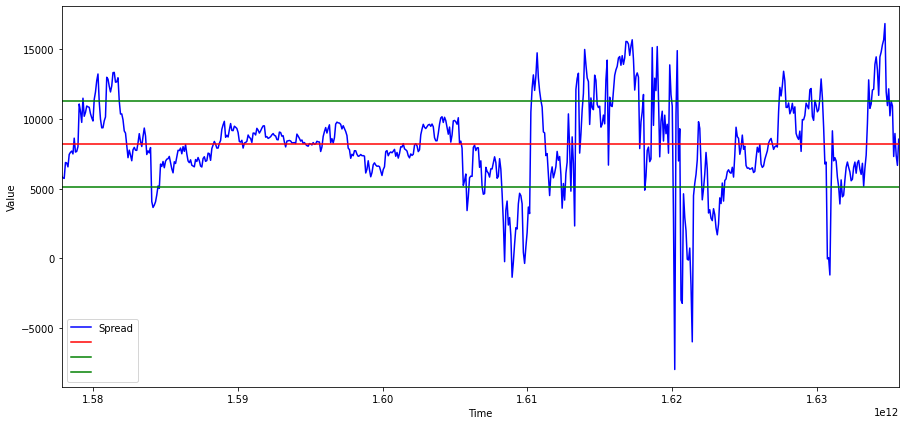

In [ ]:
############
## TEST 1 ##
############

# print("Normalizing...")
# scaler = MinMaxScaler()
# scaler.fit(X, y)
# X_scaled = scaler.transform(X) # TODO: Finish normalization
# X_scaled = pd.DataFrame(X_scaled/X_scaled[0], index=X.index) 
# X_scaled.columns = X.columns

print("Verifying coin price stationarity...")
coins = []
for coin_name in data:
    coin = Coin(coin_name)
    result = coin.is_good(data[coin_name], start_date, end_date)
    if result:
        coins.append(coin)
    else:
        print(coin_name, "is not I(1)")

print([coin.name_ for coin in coins], " are stationary \n")
        
basket = Basket(coins, target='bitcoin', processor=processor)
basket.fit(data)
spread = basket.find_spread(data)
is_cointegrated = basket.is_coint(spread)
print("\n")
print("Cointegration test returned:", is_cointegrated)

short_entry, long_entry = basket.strat(spread)

# Explore Exchanges on CoinGecko

In [ ]:
exchanges = processor.cg.get_exchanges_list()
print("There are", len(exchanges), "exchanges.")

by_24hr_vol = sorted(exchanges, key=lambda d: d['trade_volume_24h_btc'], reverse=True) 
print("Top 3 by 24 trading volume:", [exchange['id'] for exchange in by_24hr_vol[:3]])
by_trust_score = sorted(exchanges, key=lambda d: d['trust_score_rank'])
print("Top 3 by trust score:", [exchange['id'] for exchange in by_trust_score[:3]])

There are 100 exchanges.
Top 3 by 24 trading volume: ['binance', 'coinflex', 'okex']
Top 3 by trust score: ['binance', 'gdax', 'huobi']


For now just use the highest 100 market cap coins on coingecko

In [ ]:
COLS = ['id', 'current_price', 'high_24h', 'low_24h', 'market_cap', 'total_volume']

coin_market = processor.cg.get_coins_markets(vs_currency=NAT_CURR)
df_market = pd.DataFrame(coin_market, columns=COLS)
df_market.set_index('id', inplace=True)

In [ ]:
df_market

,current_price,high_24h,low_24h,market_cap,total_volume
id,,,,,
bitcoin,65391.000000,65650.00,61779.000000,1229861897003,32190166694
ethereum,4738.390000,4739.48,4543.610000,558395613225,18624112767
binancecoin,639.880000,671.09,634.620000,106730670516,3110647849
solana,248.880000,258.69,242.140000,75020361185,3066092297
tether,1.000000,1.01,0.998489,73541840465,58617616764
...,...,...,...,...,...
kucoin-shares,21.850000,22.01,18.950000,1702123532,65607704
qtum,16.270000,16.67,16.080000,1687720178,251034274
basic-attention-token,0.988842,1.01,0.985077,1475044505,136193867


From binomial theorem there are $2^{100}$ baskets so we need to find a way of filtering.

<b>There are also too many coins to pull all of them at once! We might have to create and host a database that contains updated data. We can pull around 50 or so coins at once.</b>

### Strategy
Take Pearson (Spearman?) correlation of dataframe to filter out some coins.

Idea:
We could train a model to take price data and try to spit out which coins are the most likely to be cointegrated. I think this could be some kind of 

In [ ]:
# Create portfolio dataframe
port_val = processor.create_portfolio(df_market[:50].index, start_date, end_date)
data = processor.data
# Write to CSV

In [ ]:
corr = data.corr();corr

,bitcoin,ethereum,binancecoin,solana,tether,cardano,ripple,polkadot,dogecoin,usd-coin,...,the-graph,near,monero,pancakeswap-token,eos,kusama,helium,cdai,aave,flow
bitcoin,1.000000,0.899123,0.878207,0.629661,0.265496,0.847127,0.819568,0.963216,0.698792,0.233591,...,0.881568,0.849977,0.914227,0.842050,0.682623,0.913100,0.825907,0.723792,0.920606,0.845653
ethereum,0.899123,1.000000,0.946117,0.813655,0.238686,0.963128,0.905904,0.888398,0.881139,0.239856,...,0.678033,0.855983,0.915737,0.910541,0.730628,0.908081,0.959210,0.787595,0.879152,0.708518
binancecoin,0.878207,0.946117,1.000000,0.712054,0.219670,0.921874,0.949915,0.894185,0.906667,0.240536,...,0.736031,0.819458,0.951978,0.985140,0.816919,0.936327,0.944619,0.746562,0.870759,0.815168
solana,0.629661,0.813655,0.712054,1.000000,0.200576,0.830565,0.692815,0.667566,0.621866,0.222027,...,0.339892,0.864027,0.597963,0.657673,0.414516,0.657683,0.840377,0.611079,0.525312,0.414060
tether,0.265496,0.238686,0.219670,0.200576,1.000000,0.239962,0.143786,0.232864,0.162212,0.235712,...,0.209068,0.214652,0.212250,0.196245,0.059380,0.213095,0.212362,0.257495,0.204690,0.187494
cardano,0.847127,0.963128,0.921874,0.830565,0.239962,1.000000,0.874346,0.851186,0.844869,0.267065,...,0.648215,0.850649,0.859583,0.887366,0.675500,0.892407,0.962894,0.775581,0.840201,0.711144
ripple,0.819568,0.905904,0.949915,0.692815,0.143786,0.874346,1.000000,0.831995,0.888178,0.175942,...,0.659848,0.771890,0.930199,0.938491,0.840046,0.885943,0.909358,0.686904,0.818145,0.738873
polkadot,0.963216,0.888398,0.894185,0.667566,0.232864,0.851186,0.831995,1.000000,0.712185,0.245987,...,0.894641,0.906160,0.894138,0.865578,0.737770,0.941046,0.829028,0.694045,0.917107,0.864139
dogecoin,0.698792,0.881139,0.906667,0.621866,0.162212,0.844869,0.888178,0.712185,1.000000,0.196327,...,0.526770,0.628248,0.869423,0.905842,0.810022,0.821049,0.863894,0.684964,0.773437,0.590764
usd-coin,0.233591,0.239856,0.240536,0.222027,0.235712,0.267065,0.175942,0.245987,0.196327,1.000000,...,0.196614,0.228612,0.213369,0.216195,0.139039,0.242892,0.226277,0.280270,0.196453,0.168707


In [ ]:
print("Verifying coin price stationarity...")
coins = []
for coin_name in data:
    coin = Coin(coin_name)
    result = coin.is_good(data[coin_name], start_date, end_date)
    if result:
        coins.append(coin)
    else:
        print(coin_name, "is not I(1)")

print([coin.name_ for coin in coins], " are stationary \n")

Verifying coin price stationarity...
tether is not I(1)
usd-coin is not I(1)
binance-usd is not I(1)
dai is not I(1)
['bitcoin', 'ethereum', 'binancecoin', 'solana', 'cardano', 'ripple', 'polkadot', 'dogecoin', 'shiba-inu', 'terra-luna', 'avalanche-2', 'chainlink', 'wrapped-bitcoin', 'litecoin', 'uniswap', 'matic-network', 'algorand', 'bitcoin-cash', 'vechain', 'cosmos', 'axie-infinity', 'internet-computer', 'ftx-token', 'crypto-com-chain', 'stellar', 'filecoin', 'tron', 'okb', 'compound-ether', 'theta-token', 'fantom', 'ethereum-classic', 'staked-ether', 'hedera-hashgraph', 'elrond-erd-2', 'tezos', 'the-graph', 'near', 'monero', 'pancakeswap-token', 'eos', 'kusama', 'helium', 'cdai', 'aave', 'flow']  are stationary 



(array([  2.,   2.,  10.,   6.,   8.,   4.,  18.,  14.,   4.,   8.,   4.,
          2.,   4.,   0.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,   4.,
          0.,   4.,   8.,   4.,  10.,  40.,  34.,  58.,  62.,  92., 114.,
        178., 168., 186., 292., 362., 286., 124.]),
 array([-0.9115469 , -0.86375823, -0.81596956, -0.76818089, -0.72039221,
        -0.67260354, -0.62481487, -0.5770262 , -0.52923752, -0.48144885,
        -0.43366018, -0.3858715 , -0.33808283, -0.29029416, -0.24250549,
        -0.19471681, -0.14692814, -0.09913947, -0.0513508 , -0.00356212,
         0.04422655,  0.09201522,  0.13980389,  0.18759257,  0.23538124,
         0.28316991,  0.33095858,  0.37874726,  0.42653593,  0.4743246 ,
         0.52211327,  0.56990195,  0.61769062,  0.66547929,  0.71326796,
         0.76105664,  0.80884531,  0.85663398,  0.90442265,  0.95221133,
         1.        ]),
 <BarContainer object of 40 artists>)

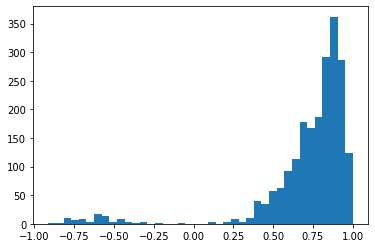

In [ ]:
coinNames = [coin.name_ for coin in coins]
df = data[coinNames].corr()
corrList = df.values.flatten()
plt.hist(corrList,bins=40)

/Users/tcintra/Desktop/trading/algo_trading/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


(array([  2.,   2.,   4.,   4.,  10.,  12.,  10.,   8.,  12.,  12.,   6.,
          2.,   0.,   2.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   6.,   2.,  10.,  14.,  42.,  58., 128., 180., 504.,
        844., 162.,  28.,   0.,   0.,   0.,  46.]),
 array([-0.77185099, -0.72755471, -0.68325844, -0.63896216, -0.59466589,
        -0.55036961, -0.50607334, -0.46177706, -0.41748079, -0.37318451,
        -0.32888824, -0.28459197, -0.24029569, -0.19599942, -0.15170314,
        -0.10740687, -0.06311059, -0.01881432,  0.02548196,  0.06977823,
         0.11407451,  0.15837078,  0.20266706,  0.24696333,  0.29125961,
         0.33555588,  0.37985215,  0.42414843,  0.4684447 ,  0.51274098,
         0.55703725,  0.60133353,  0.6456298 ,  0.68992608,  0.73422235,
         0.77851863,  0.8228149 ,  0.86711118,  0.91140745,  0.95570373,
         1.        ]),
 <BarContainer object of 40 artists>)

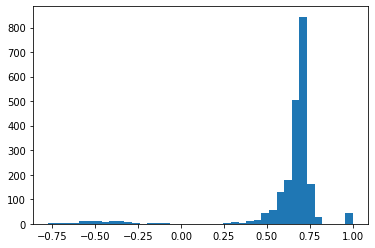

In [ ]:
df.values[[np.arange(df.shape[0])]*2] = 0
plt.hist(df.corr().values.flatten(),bins=40)